## Level Event

In this tutorial we use `judgyprophet` to forecast a time series with what we call a `level_event`. It is a sudden change in level of the time series without an underlying trend change. An example would be the following:

<AxesSubplot:>

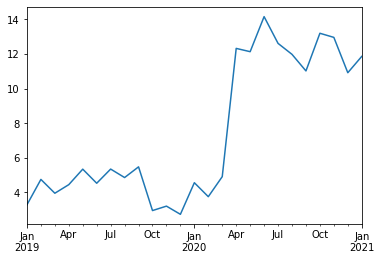

In [1]:
from judgyprophet.tutorials.resources import get_level_event
example_data = get_level_event()
example_data.plot.line()

We can see a relatively stable constant trajectory, followed by a shift in that trajectory around April 2020. It is quite stable after that.
The example above also shows the format of the data required by `judgyprophet`. The data should be a `pandas Series`, with the actuals as the entries, e.g.:
```
2019-01-01    3.287609
2019-02-01    4.753766
2019-03-01    3.955497
2019-04-01    4.451812
2019-05-01    5.345102
Freq: MS, dtype: float64
```
The index should denote the datetime element of the series, it should be ordered and have no gaps. It can either be a pandas index for specifically working with time series (e.g. `pd.DatetimeIndex`), or just an integer based index -- this means you don't have to explicitly list dates. If it is a pandas time series index, the `freq` should be set. This allows `judgyprophet` to calculate the horizon during prediction. In our case the `freq` is set to be 'MS', meaning month start.


#### Format the level event expectation for JudgyProphet
Suppose that we are aware in January 2020 that an event is likely to happen in April 2020 which will change the level by approximately 10. We would encode this in `judgyprophet` as follows:

In [2]:
level_events = [
    {'name': 'Expected event 1', 'index': '2020-04-01', 'c0': 10}
]

Each level event is encoded as a `dict` with two required entries: the `'index'` field, which is the index in the data when the event occurs. If this entry is fed into `example_data.loc[]`, then it should return a single value. It follows the standard `pandas` indexing rules (for example, see [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)). The `'c0'` field is the initial estimate by the business of what the impact of this level event will be. It is fed into the model as an informative prior on the level event mean; which is then updated in a Bayesian way.

#### Forecasting with JudgyProphet before the event occurs
Now let's pretend we're still in January 2020, and see what `judgyprophet` would have forecasted:

In [3]:
from judgyprophet import JudgyProphet

# Cutoff the data to January 2020
data_jan2020 = example_data.loc[:"2020-01-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_jan2020,
    level_events=level_events,
    trend_events=[],
    sigma_base_bias=.1,
    sigma_base_trend=.1,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Post-event data for level event Expected event 1 less than 0 points. Event deactivated in model. Event index: 2020-04-01, training data end index: 2019-01-01 00:00:00


Initial log joint probability = -56.9093
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       3      -25.5963      0.272471   1.08052e-14           1           1        6   
Optimization terminated normally: 
  Convergence detected: gradient norm is below tolerance


Let's plot the results...

<AxesSubplot:xlabel='ds', ylabel='value'>

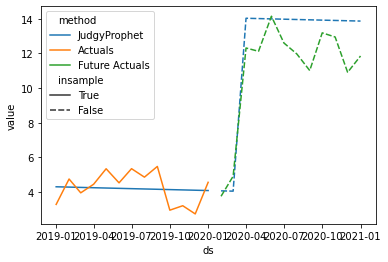

In [4]:
import pandas as pd
import seaborn as sns

predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_jan2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-02-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

We can see from the plot that the forecast captures the event pretty well. However the business estimate of the change-in-level event is probably slightly too high; which leads to the forecast to slightly overshoot the actuals.

#### Forecasting with JudgyProphet after the event occurs
This is where the Bayesian updating comes into its own. Let's now fit the forecast after the event has occurred. At this point, the impact of the event will be updated in a Bayesian way given what has been seen in the actuals.

In [5]:
# Cutoff the data to June 2020
data_june2020 = example_data.loc[:"2020-06-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_june2020,
    level_events=level_events,
    trend_events=[],
    sigma_base_bias=1.,
    sigma_base_trend=1.,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding level event Expected event 1 to model. Event index: 2020-04-01, training data start index: 2019-01-01 00:00:00, training data end index: 2020-06-01 00:00:00. Initial level: 10.


Initial log joint probability = -17.0116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       6      -2.93197   1.93616e-05   3.23115e-06           1           1        9   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Plotting the results again:

<AxesSubplot:xlabel='ds', ylabel='value'>

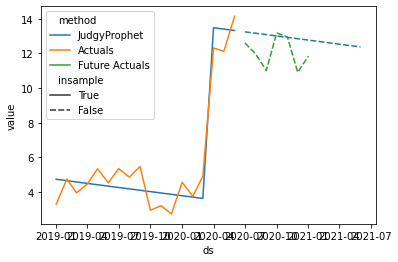

In [6]:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_june2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-07-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

When `judgyprophet` predicts after the event occurs, it decreases the business estimate as it observes actuals.